## Import PyTorch

In [3]:
%pylab inline
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Populating the interactive namespace from numpy and matplotlib


In [4]:
print(device)

cuda


## Initialize Hyper-parameters

In [5]:
input_size = 784       # The image size = 28 x 28 = 784
hidden_size = 100      # The number of nodes at the hidden layer
num_classes = 10       # The number of output classes. In this case, from 0 to 9
num_epochs = 10         # The number of times entire dataset is trained
batch_size = 100       # The size of input data took for one iteration
learning_rate = 0.001  # The speed of convergence

## Download MNIST Dataset

In [6]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

## Load the Dataset

We shuffle the loading process of train_dataset to make the learning process independent of data orderness, but the order of test_loader remains to examine whether we can handle unspecified bias order of inputs.

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4, 
                                          pin_memory=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=4, 
                                          pin_memory=True)

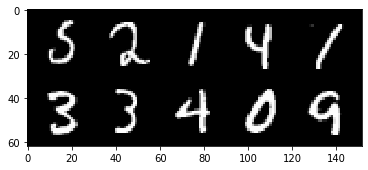

In [8]:
showimages = iter(train_loader).next()[0][:10]
grid_img = torchvision.utils.make_grid(showimages, nrow=5)
plt.imshow(grid_img.permute(1, 2, 0))

In [9]:
train_data = train_dataset.data
train_data = train_dataset.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train_dataset.data.cpu().numpy().shape)
print(' - Tensor Shape:', train_dataset.data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


## Feedforward Neural Network Model Structure

In [10]:
# class Net(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(Net, self).__init__()                    # Inherited from the parent class nn.Module
#         self.fc1 = nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer: 784 (input data) -> 500 (hidden node)
#         self.fc2 = nn.Linear(hidden_size, hidden_size) # 2nd Full-Connected Layer: 500 (hidden node) -> 10 (output class)
#         self.fc3 = nn.Linear(hidden_size, num_classes)
#         self.relu = nn.ReLU()                          # Non-Linear ReLU Layer: max(0,x)
    
#     def forward(self, x):                              # Forward pass: stacking each layer together
#         out = self.fc1(x)
#         out = self.relu(out)
#         out = self.fc2(out)
#         out = self.fc3(out)
#         return out

#net = Net(input_size, hidden_size, num_classes)


## Instantiate the FNN with dropout

In [11]:
net = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, num_classes)
)
    

## Enable GPU 

In [12]:
net.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): Dropout(p=0.5, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=10, bias=True)
)

## Choose the Loss Function and Optimizer

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

## Train the FNN Model

In [14]:
%%time
losses = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):   # Load a batch of images with its (index, data, class)
        images = torch.FloatTensor(images.view(-1, 28*28))         # Convert torch tensor to Variable: change image from a vector of size 784 to a matrix of 28 x 28
        labels = torch.LongTensor(labels)
        
        images = images.to(device)
        labels = labels.to(device)
        
        
        optimizer.zero_grad()                             # Intialize the hidden weight to all zeros
        outputs = net(images)                             # Forward pass: compute the output class given a image
        loss = criterion(outputs, labels)                 # Compute the loss: difference between the output class and the pre-given label
        losses.append(loss.cpu().item())
        loss.backward()                                   # Backward pass: compute the weight
        optimizer.step()                                  # Optimizer: update the weights of hidden nodes
        
        if (i+1) % 100 == 0:                              # Logging
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.item()))

Epoch [1/10], Step [100/600], Loss: 0.6217
Epoch [1/10], Step [200/600], Loss: 0.3814
Epoch [1/10], Step [300/600], Loss: 0.5068
Epoch [1/10], Step [400/600], Loss: 0.3905
Epoch [1/10], Step [500/600], Loss: 0.3314
Epoch [1/10], Step [600/600], Loss: 0.3337
Epoch [2/10], Step [100/600], Loss: 0.3424
Epoch [2/10], Step [200/600], Loss: 0.3502
Epoch [2/10], Step [300/600], Loss: 0.2548
Epoch [2/10], Step [400/600], Loss: 0.2140
Epoch [2/10], Step [500/600], Loss: 0.2439
Epoch [2/10], Step [600/600], Loss: 0.1245
Epoch [3/10], Step [100/600], Loss: 0.3972
Epoch [3/10], Step [200/600], Loss: 0.1854
Epoch [3/10], Step [300/600], Loss: 0.3787
Epoch [3/10], Step [400/600], Loss: 0.1572
Epoch [3/10], Step [500/600], Loss: 0.2507
Epoch [3/10], Step [600/600], Loss: 0.1880
Epoch [4/10], Step [100/600], Loss: 0.1374
Epoch [4/10], Step [200/600], Loss: 0.1145
Epoch [4/10], Step [300/600], Loss: 0.0815
Epoch [4/10], Step [400/600], Loss: 0.2026
Epoch [4/10], Step [500/600], Loss: 0.2368
Epoch [4/10

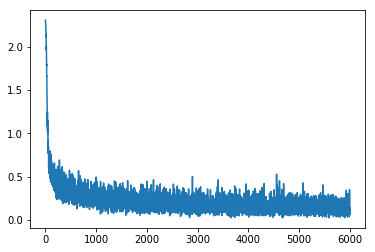

In [12]:
plot(losses)

## Test the FNN Model

Similar to training the nerual network, we also need to load batches of test images and collect the outputs. The differences are that:
(1) No loss & weights calculation
(2) No wights update
(3) Has correct prediction calculation

In [13]:
correct = 0
total = 0
net.eval()
for images, labels in test_loader:
    images = torch.FloatTensor(images.view(-1, 28*28))
    
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
    total += labels.size(0)                    # Increment the total count
    correct += (predicted == labels).sum()     # Increment the correct count
    
print('Accuracy of the network on the 10K test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10K test images: 97 %


## Save the trained FNN Model for future use

In [14]:
# Save the model
torch.save(net.state_dict(), 'fnn_model.pkl')